In [1]:
import numpy as np
import matplotlib.pyplot as plt

# To-do

* Plotting
* Tests
* Calculate fw for #2 side

In [177]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, RegularPolygon
import numpy as np
from numpy import radians as rad

def drawCirc(ax,radius,centX,centY,angle_,theta2_,color_='black'):
    # https://stackoverflow.com/questions/37512502/how-to-make-arrow-that-loops-in-matplotlib
    #========Line
    arc = Arc([centX,centY],radius,radius,angle=angle_,
          theta1=0,theta2=theta2_,capstyle='round',linestyle='-',lw=2.5,color=color_)
    ax.add_patch(arc)


    #========Create the arrow head
    endX=centX+(radius/2)*np.cos(rad(theta2_+angle_)) #Do trig to determine end position
    endY=centY+(radius/2)*np.sin(rad(theta2_+angle_))

    ax.add_patch(                    #Create triangle as arrow head
        RegularPolygon(
            xy=(endX, endY),
            numVertices=3,                      
            radius=radius/9,
            orientation=rad(angle_+theta2_),     
            facecolor=color_
        )
    )
    # ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius]) 
    # Make sure you keep the axes scaled or else arrow will distort

In [178]:
class AppliedLoad():

    def __init__(
        self,
        coords,
        load,
    ):
        
        self.coords = coords
        self.load = load

In [179]:
class WeldLine():

    def __init__(
        self,
        points,
    ):
        # assert isinstance(pts) is np.array

        self.points = np.asarray(points)
        self.x1 = points[0]
        self.y1 = points[1]
        self.x2 = points[2]
        self.y2 = points[3]

    @property
    def l(self):
        return np.linalg.norm(self.points[:2] - self.points[2:])

    @property
    def x_cg(self):
        return np.mean(np.array([self.points[0], self.points[2]]))

    @property
    def y_cg(self):
        return np.mean(np.array([self.points[1], self.points[3]]))

    @property
    def xc(self):
        return self.x_cg * self.l

    @property
    def yc(self):
        return self.y_cg * self.l
    
    @property
    def Ix(self):
        """ Calculate moment of inertia about x-axis"""
        return self.l * (self.y2 - self.y1)**2/12 + self.l * self.y_cg**2

    @property
    def Iy(self):
        """ Calculate moment of inertia about x-axis"""
        return self.l * (self.x2 - self.x1)**2/12 + self.l * self.x_cg**2

In [180]:
import inspect

class WeldGroup():

    def __init__(
        self,
        welds,
        applied_loads,
    ):
        
        self.welds = welds
        self.applied_loads = applied_loads
        # assert inspect.isclass(weld, type(WeldLine))

    @property
    def l(self):
        return np.sum([w.l for w in self.welds])

    @property
    def sum_cx(self):
        return np.sum([w.xc for w in self.welds])
    
    @property
    def sum_cy(self):
        return np.sum([w.yc for w in self.welds])
    
    @property
    def sum_Ix(self):
        return np.sum([w.Ix for w in self.welds])
    
    @property
    def sum_Iy(self):
        return np.sum([w.Iy for w in self.welds])
    
    @property
    def cx(self):
        return self.sum_cx / self.l  
    
    @property
    def cy(self):
        return self.sum_cy / self.l   

    @property
    def Ix(self):
        return self.sum_Ix - self.l * self.cy**2     
    
    @property
    def Iy(self):
        return self.sum_Iy - self.l * self.cx**2       
    
    @property
    def J(self):
        return self.Ix + self.Iy       

    @property
    def applied_moment(self):
        m = []
        for load in self.applied_loads:
            # r = np.insert(np.asarray(load.coords[:2]), 2, 0.0) - np.asarray([3, 2.5, 6])
            r = np.array([self.cx, self.cy, 0]) - load.coords 
            m.append(np.cross(r, load.load[:3]))
        return np.asarray(m)
    
    @property
    def moments(self):
        sum_of_applied_moments = np.sum([np.asarray(x.load[3:]) for x in self.applied_loads],0)
        return np.add(np.sum(self.applied_moment, axis=0), sum_of_applied_moments)
    
    @property
    def forces(self):
        return np.sum(np.asarray([x.load[:3] for x in self.applied_loads]), axis=0)
    
    def calculate_weld_forces(self):
        # Need to add calculation for #2 side -- code below is just #1
        for weld in self.welds:
            weld.f_n = -self.forces[2] / self.l 
            weld.f_bx = self.moments[0] * (self.cy - weld.y1) / self.Ix
            weld.f_by = self.moments[1] * (self.cx - weld.x1) / self.Iy
            weld.f_sx = self.forces[0] / self.l + self.moments[2] * (self.cy - weld.y1) / self.J
            weld.f_sy = self.forces[1] / self.l + self.moments[2] * (self.cx - weld.x1) / self.J
            weld.fw = np.sqrt((weld.f_n + weld.f_bx + weld.f_by)**2 + weld.f_sx**2 + weld.f_sy**2)
            # return f_n, f_bx, f_by, f_sx, f_sy, f_weld # f_weld = np.sqrt()
            # weld.fw = f_weld

    def plot(self):
        fig, ax = plt.subplots(1,2, figsize=(16,8))
        for weld in self.welds:
            ax[0].plot([weld.x1, weld.x2], [weld.y1, weld.y2], color='black', lw=10.0)

        ax[0].scatter(x=self.cx, y=self.cy, marker='x', color='red', s=200)
        
        for load in self.applied_loads:
            ax[0].scatter(x=load.coords[0], y=load.coords[1], marker='+', color='blue', s=200)

        for load in self.applied_loads:
            # draw weld side view
            ax[1].plot([weld.x1, weld.x2], [weld.y1, weld.y2], color='black', lw=10.0)
            # draw line connecting applied load with weld side view
            ax[1].plot([weld.x1, load.coords[2]], [weld.y2/2, weld.y2/2], color='black', lw=1.5, ls='--')
            # draw marker for applied load
            ax[1].scatter(x=load.coords[2], y=load.coords[1], marker='+', color='blue', s=200) 

        ax[0].grid(visible=True, which='both', axis='both')
        ax[0].set_xlabel('$x$-axis (in)')
        ax[0].set_ylabel('$y$-axis (in)')
        ax[0].set_title('Front view (looking at weld)')
        
        ax[1].grid(visible=True, which='both', axis='both')
        ax[1].set_xlabel('$z$-axis (in)')
        ax[1].set_title('Side view')
        # TODO
        # drawCirc(ax=ax[1], radius=0.5, centX=load.coords[2], centY=load.coords[1], angle_=90, theta2_=330)

        ax[1].annotate("$P_y$ = {}".format(self.forces[1]), xy=(load.coords[2], load.coords[1]), 
                       xytext=(load.coords[2], load.coords[1]+0.8), xycoords='data',
                       ha='center', va='center',
                       bbox=dict(facecolor='white', edgecolor='black'),
                       arrowprops={'arrowstyle': '->', 'color':'red', 'linewidth':2.0})

        plt.show()

In [181]:
weld_1 = np.array([6/2 - 0.375/2, 0.0, 6/2 - 0.375/2, 5])
weld_2 = np.array([6/2 + 0.375/2, 0.0, 6/2 + 0.375/2, 5])
f = AppliedLoad([3.0, 2.5, 6.0], [146, -2810, 3000, 0.0,0.0,0.0])

weld_1 = WeldLine(weld_1)
weld_2 = WeldLine(weld_2)

x = WeldGroup([weld_1, weld_2], applied_loads=[f])
x.calculate_weld_forces()

weld_1.fw
weld_2.fw

1877.2080758402897

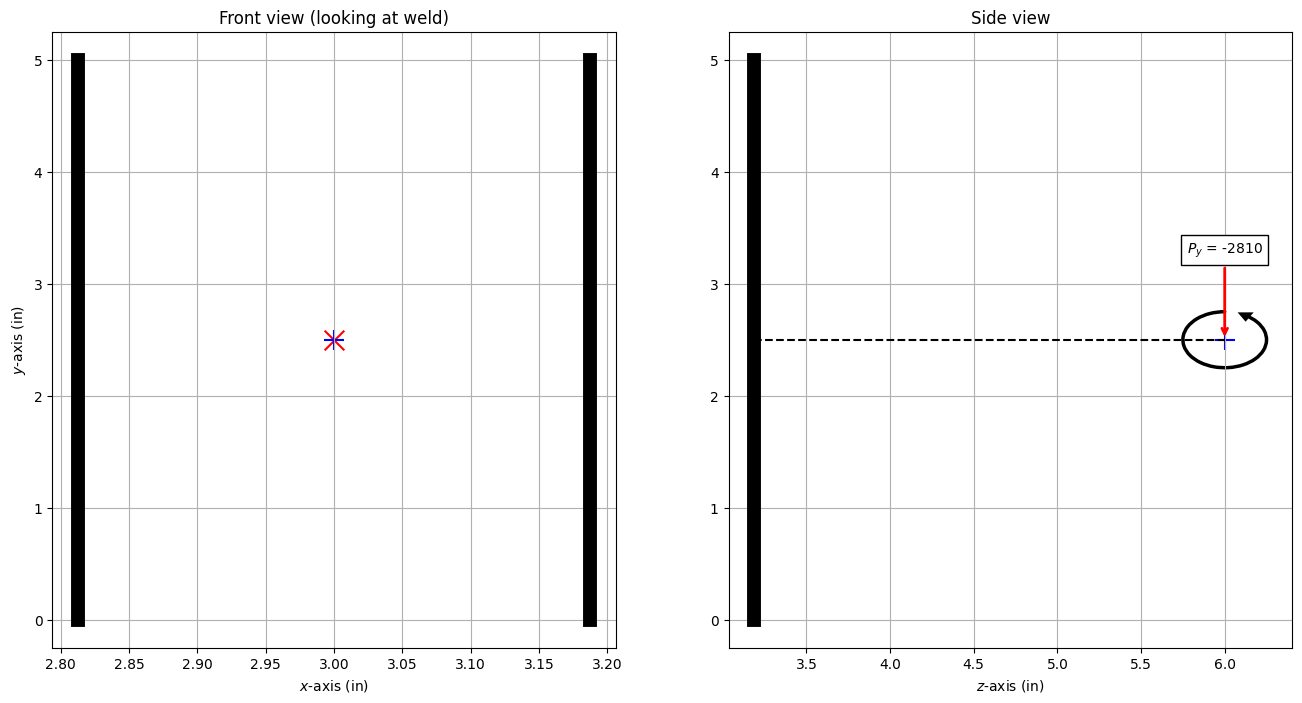

In [182]:
x.plot()

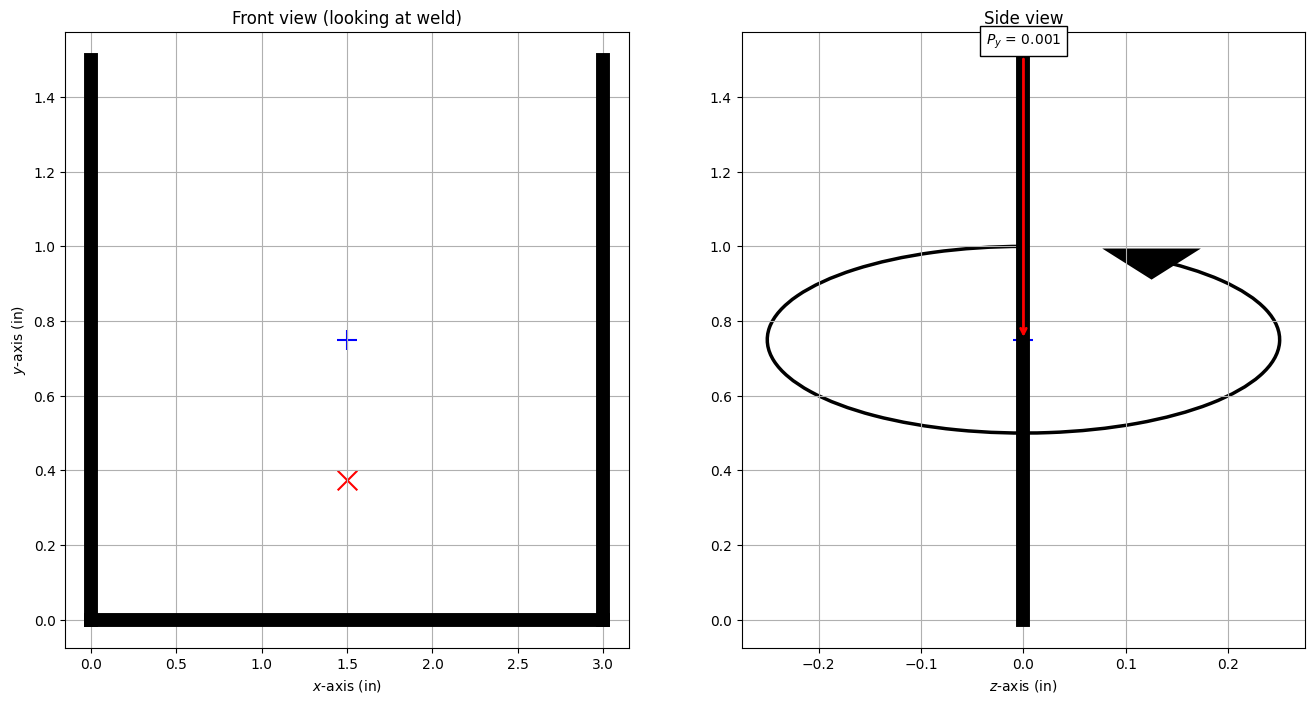

In [229]:
l1 = 3
l2 = 1.5

weld_1 = np.array([0.0, 0.0, l1, 0])
weld_2 = np.array([l1, 0, l1, l2])
# weld_3 = np.array([l1, l2, 0, l2])
weld_4 = np.array([0, l2, 0, 0])
# weld_2 = np.array([-l2, -l2, l2])
# weld_1 = np.array([l1, 0.0, l2, 0])
# weld_1 = np.array([l1, 0.0, l2, 0])
# weld_2 = np.array([6/2 + 0.375/2, 0.0, 6/2 + 0.375/2, 5])
axial = 23.93
moment_p1 = 1777.9
moment_p2 = 0.01
shear_p1 = 65.8
shear_p2 = 0.001
torque = 0.015

f = AppliedLoad([l1/2, l2/2, 0.0], [shear_p1, shear_p2, axial, moment_p1, moment_p2, torque])

weld_1 = WeldLine(weld_1)
weld_2 = WeldLine(weld_2)
# weld_3 = WeldLine(weld_3)
weld_4 = WeldLine(weld_4)

x = WeldGroup([weld_1, weld_2, weld_4], applied_loads=[f])
x.calculate_weld_forces()

x.plot()

In [230]:
print(weld_1.fw)
print(weld_2.fw)
# print(weld_3.fw)
print(weld_4.fw)

467.8907861400072
467.8874514380701
1419.15638656262


In [216]:
print((24000 / (np.sqrt(3) * 2 * 1.1)))
t_w = 2861 / (24000 / (np.sqrt(3) * 2 * 1.1))

S = t_w * np.sqrt(2)
S

6298.366572977736


0.6423990974594117

In [219]:
t_w_design = 0.2 /  np.sqrt(2)
F_w = (24000 / (np.sqrt(3) * 2 * 1.1))

(t_w_design) / t_w - 1

-0.6886670594791169

In [221]:
(9091 / 19843) - 1

-0.5418535503704077